Optimal L: 0.02
Optimal B: 0.15000000000000002
Net PnL: 33859.41445500895
Max Drawdown: 5404.1455129369315
Hit Ratio: 0.520888418826018


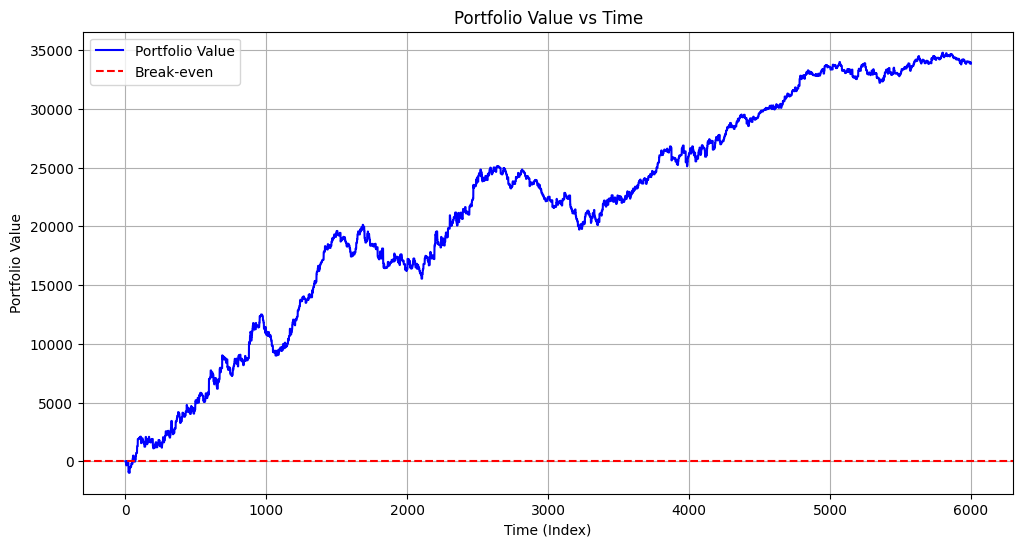

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brute

# Load the CSV file
file_path = 'C:/Users/ASUS/Downloads/assign6.csv'
data = pd.read_csv(file_path)

# Define the dual-threshold strategy function
def dual_threshold_strategy(data, L, B):
    """
    Simulates the dual-threshold strategy given thresholds L and B.
    Returns the portfolio values over time and metrics.
    """
    position = 0  # No position initially (0: none, 1: long, -1: short)
    entry_price = 0
    portfolio_value = [0]  # Assume starting portfolio value is 0
    trades = []  # To store trade outcomes (PnL per trade)

    for i, row in data.iterrows():
        alpha = row['alpha']
        price = row['price']
        
        # Implementing the strategy
        if position == 0:  # No active position
            if alpha > B:  # Enter long
                position = 1
                entry_price = price
            elif alpha < -B:  # Enter short
                position = -1
                entry_price = price

        elif position == 1:  # Long position
            if alpha < L:  # Liquidate long
                pnl = price - entry_price
                trades.append(pnl)
                portfolio_value.append(portfolio_value[-1] + pnl)
                position = 0

        elif position == -1:  # Short position
            if alpha > -L:  # Liquidate short
                pnl = entry_price - price
                trades.append(pnl)
                portfolio_value.append(portfolio_value[-1] + pnl)
                position = 0

        # Update portfolio value (carry forward if no trade happened)
        if len(portfolio_value) <= i:
            portfolio_value.append(portfolio_value[-1])

    # Final portfolio metrics
    pnl_total = sum(trades)
    max_drawdown = max(0, max(np.maximum.accumulate(portfolio_value) - portfolio_value))
    hit_ratio = len([t for t in trades if t > 0]) / len(trades) if trades else 0

    return pnl_total, max_drawdown, hit_ratio, portfolio_value

# Optimize thresholds L and B using brute-force search
def optimize_thresholds(data, L_range, B_range):
    """
    Optimizes the thresholds L and B to maximize net PnL.
    """
    def objective(thresholds):
        L, B = thresholds
        pnl, _, _, _ = dual_threshold_strategy(data, L, B)
        return -pnl  # Negative for minimization

    ranges = (L_range, B_range)
    result = brute(objective, ranges, full_output=True, finish=None)
    optimal_L, optimal_B = result[0]
    return optimal_L, optimal_B

# Define the ranges for L and B
L_range = slice(0.01, 0.10, 0.01)
B_range = slice(0.10, 0.50, 0.05)

# Optimize L and B
optimal_L, optimal_B = optimize_thresholds(data, L_range, B_range)

# Evaluate strategy with optimal thresholds
pnl, max_drawdown, hit_ratio, portfolio_value = dual_threshold_strategy(data, optimal_L, optimal_B)

# Print results
print("Optimal L:", optimal_L)
print("Optimal B:", optimal_B)
print("Net PnL:", pnl)
print("Max Drawdown:", max_drawdown)
print("Hit Ratio:", hit_ratio)

# Plot portfolio value over time
plt.figure(figsize=(12, 6))
plt.plot(portfolio_value, label='Portfolio Value', color='blue')
plt.title('Portfolio Value vs Time')
plt.xlabel('Time (Index)')
plt.ylabel('Portfolio Value')
plt.axhline(0, color='red', linestyle='--', label='Break-even')
plt.legend()
plt.grid()
plt.show()
